In [1]:
import snap
import time, gensim, pickle, json, networkx as nx, numpy as np
from networkx.readwrite import json_graph

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('twitter_users_graph2.json', 'r') as f:
    data = json.load(f)
    nxg = json_graph.node_link_graph(data, directed=True)
nxg = nxg.to_directed()

In [3]:
def networkx_to_snappy(nxg, directed=False):
    if directed:
        g = snap.PNGraph.New()
    else:
        g = snap.PUNGraph.New()
        
    for n in nxg.nodes():
        g.AddNode(n)
    for f,t in nxg.edges():
        g.AddEdge(f, t)
        
    return g
    

## 1) Degree
## 2) Betweenness
## 3) Eigenvector Centrality
## 4) Closeness Centrality
## 5) Page rank
## 6) Modularity*
## 7) Network Diameter*
## 8) Number of Communities*
#### * means this metric is for the network as a whole, not the average of each node

# Degree

<Container object of 54 artists>

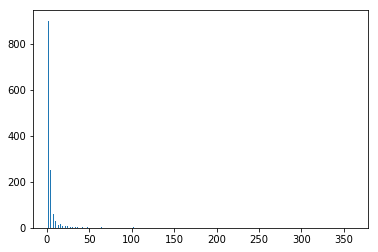

In [4]:
# Histogram
Graph = networkx_to_snappy(nxg, directed=True)
DegToCntV = snap.TIntPrV()
snap.GetDegCnt(Graph, DegToCntV)
degrees_counts = sorted([(item.GetVal1(),item.GetVal2()) for item in DegToCntV])
plt.bar([x[0] for x in degrees_counts], [y[1] for y in degrees_counts])

In [5]:
degrees_counts

[(2, 900),
 (4, 250),
 (6, 98),
 (8, 60),
 (10, 28),
 (12, 20),
 (14, 11),
 (16, 15),
 (18, 7),
 (20, 6),
 (22, 7),
 (24, 9),
 (26, 1),
 (28, 4),
 (30, 2),
 (32, 1),
 (34, 3),
 (36, 3),
 (38, 1),
 (40, 1),
 (42, 4),
 (44, 1),
 (48, 2),
 (58, 2),
 (60, 1),
 (62, 1),
 (64, 2),
 (66, 3),
 (68, 1),
 (72, 1),
 (76, 1),
 (80, 1),
 (84, 1),
 (86, 1),
 (90, 1),
 (96, 1),
 (102, 2),
 (104, 1),
 (112, 1),
 (116, 1),
 (126, 1),
 (156, 1),
 (170, 1),
 (176, 1),
 (196, 1),
 (210, 1),
 (224, 1),
 (228, 1),
 (246, 1),
 (258, 1),
 (262, 1),
 (292, 1),
 (326, 1),
 (360, 1)]

<Container object of 15 artists>

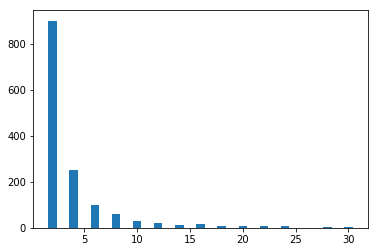

In [6]:
plt.bar([x[0] for x in degrees_counts[:15]], [y[1] for y in degrees_counts[:15]])

# Let's flood our graph
<img src="https://www.nasa.gov/images/content/134306main_pia06674.gif" />

In [7]:
for ix,deg in nxg.degree(nxg.nodes()):
    nxg.node[ix]['degree'] = deg
    nxg.node[ix]['parity'] = (1-deg%2)
    
for ix,in_deg in nxg.in_degree(nxg.nodes()):
    nxg.node[ix]['in_degree'] = in_deg
    
for ix,out_deg in nxg.out_degree(nxg.nodes()):
    nxg.node[ix]['out_degree'] = out_deg

In [8]:
start = time.time()
evc = nx.eigenvector_centrality(nxg)
closeness = nx.closeness_centrality(nxg)
betweenness = nx.betweenness_centrality(nxg)
pagerank = nx.pagerank(nxg)
cntr_metrics = {"eigenvector_centrality":evc,
           "closeness_centrality":closeness,
              "betweenness":betweenness,
               "pagerank":pagerank}
print("Took: ", time.time()-start)

('Took: ', 11.656232833862305)


In [9]:
for metric_name, metric in cntr_metrics.items():
    for ix,v in metric.items():
        nxg.node[ix][metric_name] = v

In [22]:
nxg.nodes[133]

{u'betweenness': 4.383264653312519e-05,
 u'cleaned_twitter_name': u'mehmet ekinci',
 u'closeness_centrality': 0.2862431800467654,
 u'degree': 6,
 u'eigenvector_centrality': 0.013167920875487035,
 u'favourites_count': 21273,
 u'followers_count': 35287,
 u'friends_count': 595,
 'in_degree': 3,
 u'lang': u'tr',
 'out_degree': 3,
 'pagerank': 0.0005010176118114327,
 u'parity': 1,
 u'sehir_matches': u' mehmet akinci',
 u'statuses_count': 24993,
 u'twitter_name': u'Mehmet EK\u0130NC\u0130',
 u'twitter_screen_name': u'MehmetEkinci63'}

In [31]:
def get_island(graph, level, metric):
    island = graph.copy()
    for node in graph.nodes():
        if graph.nodes[node][metric]<level:
            island.remove_node(node)
            
    return island

In [32]:
cntr_range = [i/10.0 for i in range(11)]  # 0 to 1
ranges = [("degree",range(0, 31, 2)),
          ("in_degree",range(0, 31, 2)),
          ("out_degree",range(0, 31, 2)),
          ("eigenvector_centrality",cntr_range),
          ("closeness_centrality",cntr_range),
          ("betweenness",cntr_range),
          ("pagerank",cntr_range)]

## for parallelization
def get_islands(metric, range_):
    return {level:get_island(nxg, level, metric) for level in range_}

In [33]:
# from joblib import parallel, delay

# islands = Parallel(n_jobs=-1)(
#                             delayed(get_islands)
#                             (metric, range_)
#                             for metric,range_ in ranges)

In [54]:
islands = {metric:get_islands(metric, range_) for metric,range_ in ranges}

In [55]:
islands.keys()

['closeness_centrality',
 'out_degree',
 'degree',
 'in_degree',
 'betweenness',
 'eigenvector_centrality',
 'pagerank']

In [56]:
def get_avg_metric(graph, metric):
    result = 0.0
    for node in graph.nodes():
        result += graph.nodes[node][metric]
    return result/len(graph.nodes)

In [68]:
def describe_island(island):
    if len(island.nodes())<1:
        description = {"modularity":None,
            "communities":None,
            "diameter_dir":None,
            "diameter_undir": None}
        for metric, _ in ranges:
            description["avg_"+metric] = None
        return description
    island_snappy = networkx_to_snappy(island)
    CmtyV = snap.TCnComV()
    start = time.time()
    
    modularity = snap.CommunityGirvanNewman(island_snappy, CmtyV)
    num_of_communities = len(CmtyV)
    print("calculated modularity, Took: ", time.time()-start)
    directed_island_snappy = networkx_to_snappy(island, True)
    diam_directed = snap.GetBfsFullDiam(directed_island_snappy, 100, True)
    diam_undirected = snap.GetBfsFullDiam(island_snappy, 100, False)
    description = {"modularity":modularity,
            "communities":num_of_communities,
            "diameter_dir":diam_directed,
            "diameter_undir": diam_undirected}
    for metric, _ in ranges:
        description["avg_"+metric] = get_avg_metric(island, metric)
    return description

In [69]:
islands_described = {metric:{
    level:describe_island(island) for level, island in levels.items()}
                     for metric,levels in islands.items()}

('calculated modularity, Took: ', 531.4226760864258)
('calculated modularity, Took: ', 555.4742681980133)
('calculated modularity, Took: ', 0.00011110305786132812)
('calculated modularity, Took: ', 22.356173038482666)
('calculated modularity, Took: ', 534.9627759456635)
('calculated modularity, Took: ', 529.5784118175507)
('calculated modularity, Took: ', 131.06810879707336)
('calculated modularity, Took: ', 17.28294801712036)
('calculated modularity, Took: ', 4.977022886276245)
('calculated modularity, Took: ', 2.0906341075897217)
('calculated modularity, Took: ', 0.9230711460113525)
('calculated modularity, Took: ', 0.4794158935546875)
('calculated modularity, Took: ', 0.2424330711364746)
('calculated modularity, Took: ', 0.18091988563537598)
('calculated modularity, Took: ', 0.08350610733032227)
('calculated modularity, Took: ', 0.05338692665100098)
('calculated modularity, Took: ', 0.03132200241088867)
('calculated modularity, Took: ', 0.0260159969329834)
('calculated modularity, T

In [70]:
with open('../datasets/twitter_islands.pkl', 'wb') as f:
    pickle.dump(islands, f, protocol=2)
    
with open('../datasets/twitter_islands_describ.pkl', 'wb') as f:
    pickle.dump(islands_described, f, protocol=2)

In [71]:
data = nx.node_link_data(nxg)
with open('../visualization/twitter_users_graph2.json', 'w') as f:
    json.dump(data, f, indent=4)
    
with open('../REST/static/networks/twitter_users_graph2.json', 'w') as f:
    json.dump(data, f, indent=4)